# Visualizing Barren Plateaus

[References](https://github.com/Gopal-Dahale/ILearnQuantum/blob/main/layerwise_learning_with_qiskit_and_pytorch/barren_plateaus_visualization.ipynb)

In [9]:
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit
import os
from qiskit.primitives import Estimator

seed = 42
np.random.seed(seed)

In [10]:
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
import torch
from torch import nn
import pandas as pd

from sklearn.decomposition import PCA

from Components.train import train, train_batch
from Components.data import cancer_data
from Components.circuits import *
from Components.gradients import *
from Components.log_ops import *
from Components.utils import *

In [11]:
X_train, X_val, y_train, y_val = cancer_data(PCA_n = 4)
# X_train, X_val, y_train, y_val = fetch_mnist(PCA_n = FEATURE_DIM, data_size=DATA_SIZE)
# X_train, X_val, y_train, y_val = iris(pd=False, PCA_n=None)

X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

Training set: 398 samples
Testing set: 171 samples
Number of features: 4
PCA Explained variance: [4.43782605e+05 7.31010006e+03 7.03833742e+02 5.46487379e+01]
Classes:[0 1]; Encoded as: [-1  1]


In [12]:
estimator = Estimator()

/Users/ncng/.local/share/virtualenvs/VQA-Notes-v2-orAwPlel/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


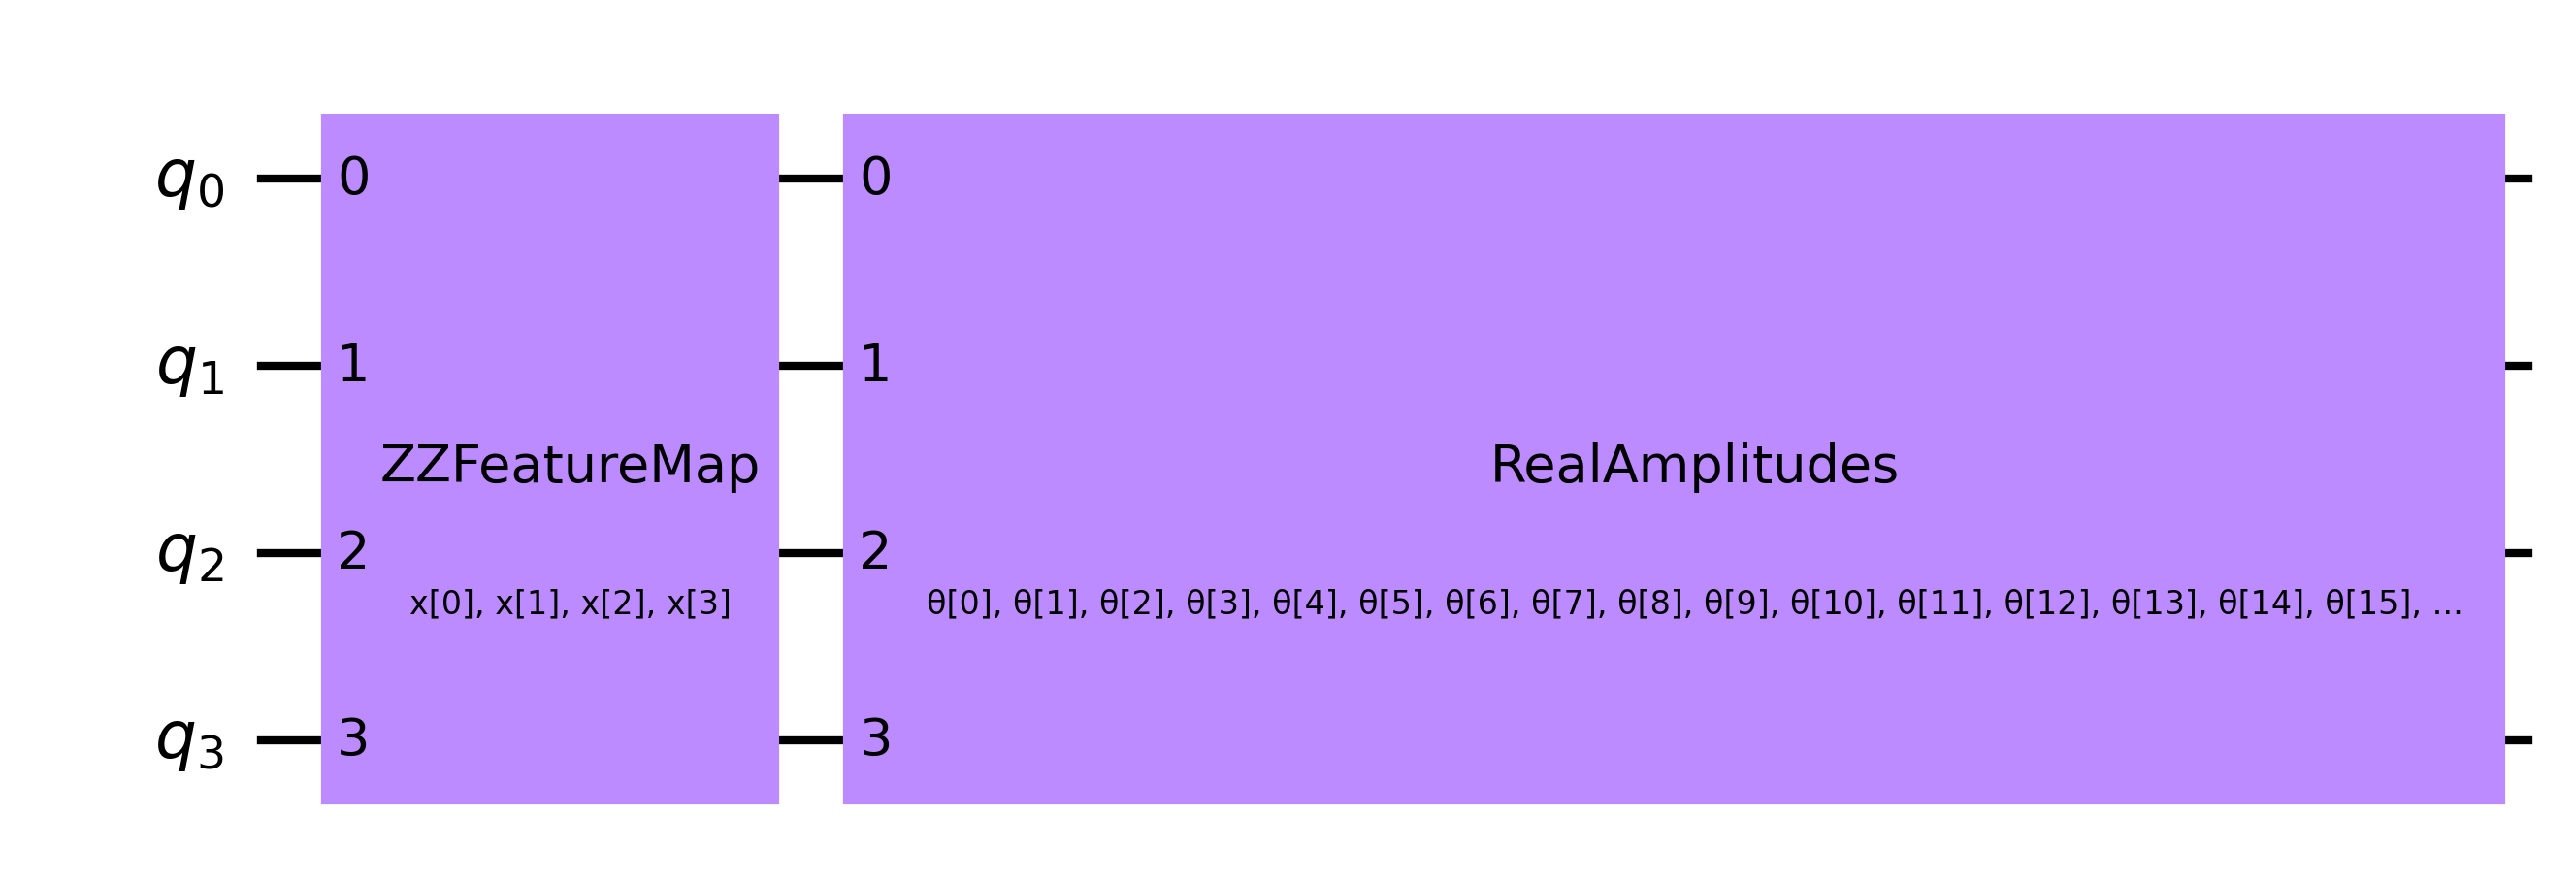

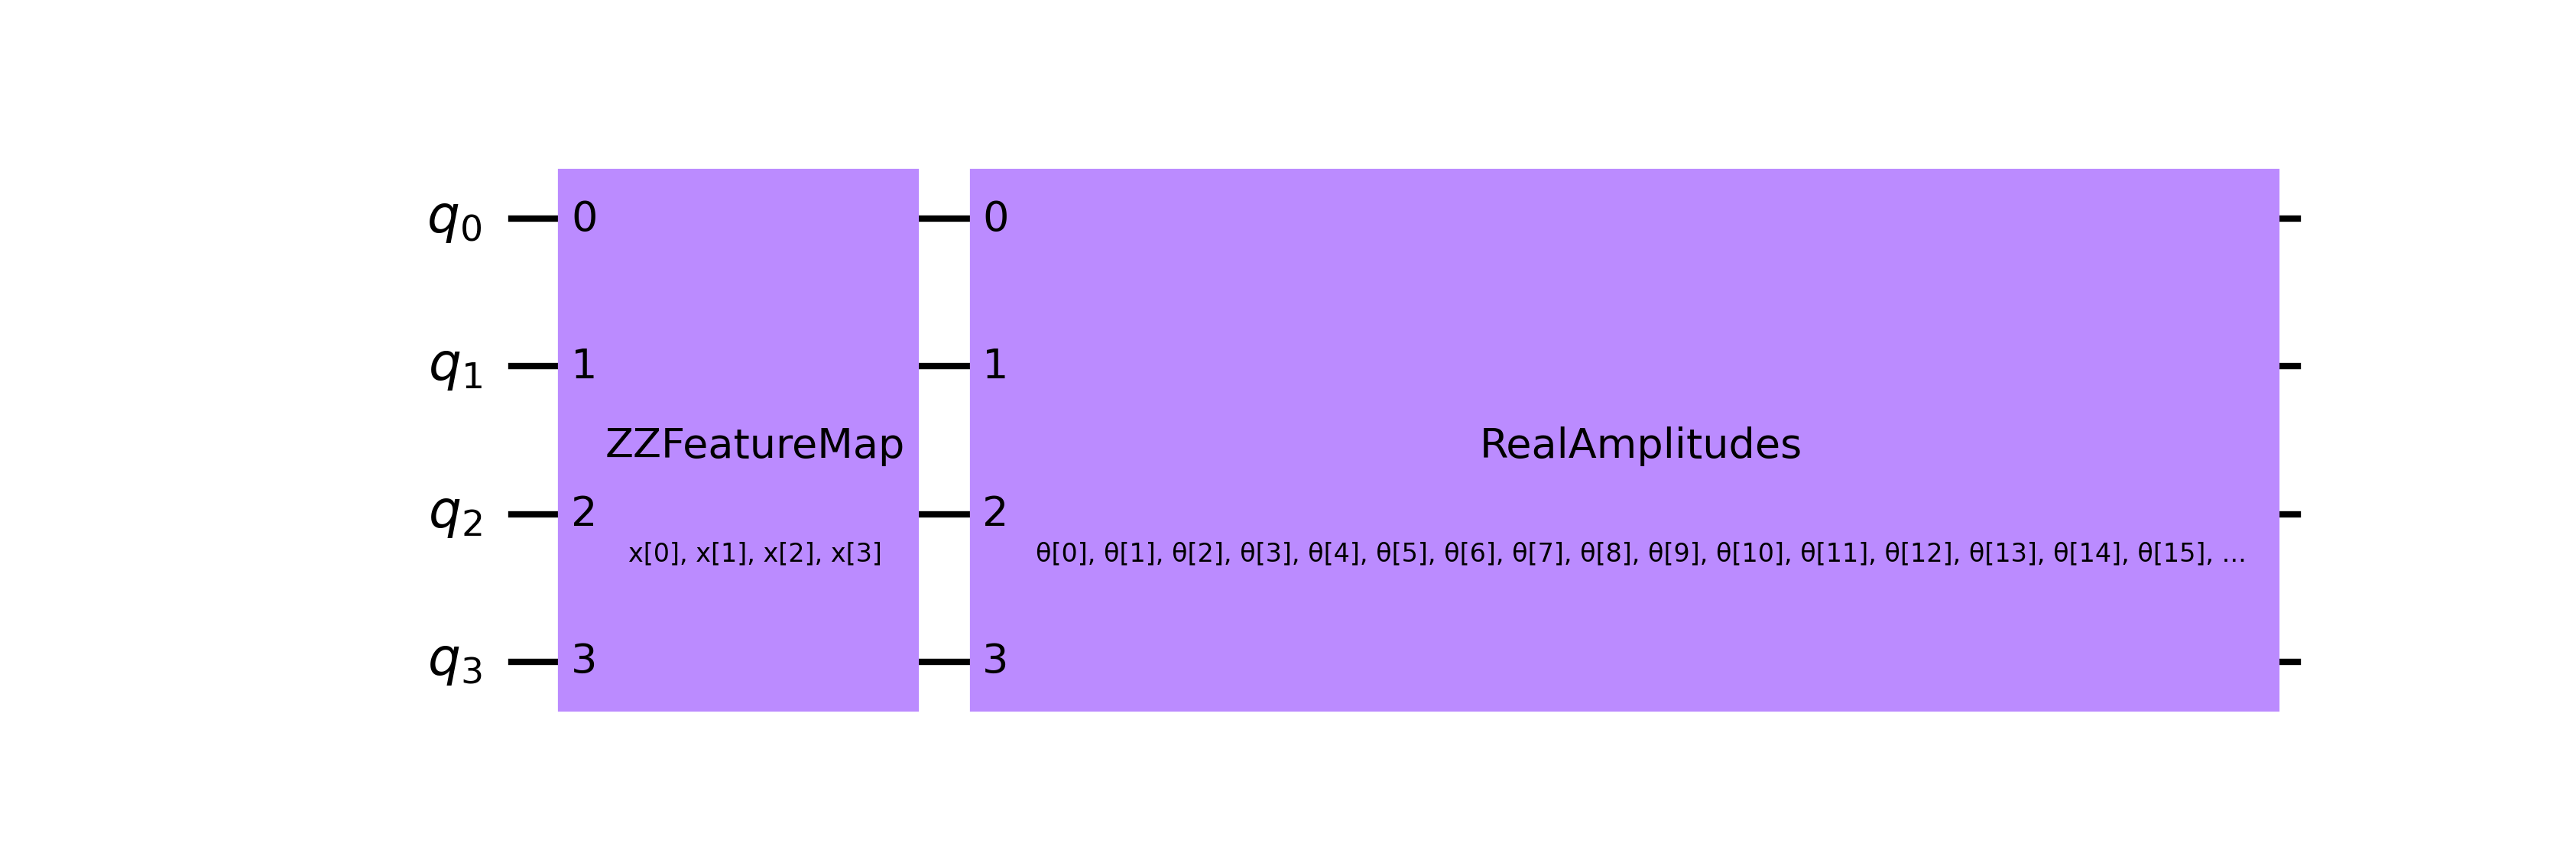

In [13]:
feature_map = featureMapGenerator(4)
ansatz = AnsatzGenerator(4, 4, ENTANGLEMENT)

qc = circuitBuilder(feature_map, ansatz, 'middle')
qc.draw('mpl')

In [14]:
randompoint = np.random.uniform(0, np.pi/2, ansatz.num_parameters)

In [26]:
# print('randompoint = ', randompoint)
# X = np.arange(-np.pi, np.pi, 0.25)
# Y = np.arange(-np.pi, np.pi, 0.25)
# X, Y = np.meshgrid(X, Y)
# for x in X[0, :]:
#     for y in Y[:, 0]:
#         rotations = np.array([x, y])
#         print(rotations)

res = pd.DataFrame()
GLOBAL_OPERATOR = SparsePauliOp.from_list([('Z'*qc.num_qubits, 1)])
for i in range(0, 20):
    print('iteration: ', i)
    display(res)
    initial_point = np.random.uniform(0, 0.1, ansatz.num_parameters)
    
    qnn = EstimatorQNN(
        circuit=qc,
        estimator=Estimator(),
        observables=GLOBAL_OPERATOR,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters
    )

    model = TorchConnector(qnn, initial_weights=initial_point)

    loss_function = nn.L1Loss() #This is MAE loss
    optimizer = torch.optim.NAdam(model.parameters(), lr=0.05)

    loss, weight = sampleWeightLoss(
        model, 
        X_train_t,
        y_train_t,
        optimizer = optimizer, 
        loss_function = loss_function
        )
    res = pd.concat([res, pd.DataFrame(np.append(weight.numpy(), loss.numpy())).transpose()], ignore_index=True) 
    clear_output(wait=True)


iteration:  19


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.089208,0.095533,0.078690,0.031541,0.068813,0.043760,0.025467,0.084087,0.003843,0.090176,...,0.063720,0.065935,0.089512,0.063667,0.061393,0.006665,0.051841,0.015017,0.073743,1.014387
1,0.051222,0.068023,0.004167,0.008479,0.071632,0.007208,0.007126,0.001211,0.095650,0.073751,...,0.029654,0.034970,0.077465,0.066137,0.018520,0.017411,0.009840,0.066030,0.076437,1.011464
2,0.026505,0.002094,0.008217,0.096786,0.029544,0.076922,0.062466,0.038194,0.020569,0.012139,...,0.077463,0.064390,0.053030,0.004195,0.096849,0.079871,0.029282,0.097997,0.060188,1.008246
3,0.058242,0.074807,0.081177,0.065648,0.012810,0.033827,0.092808,0.022462,0.037217,0.043208,...,0.061294,0.094308,0.024069,0.012150,0.019747,0.088692,0.064581,0.028591,0.081595,1.014470
4,0.086137,0.084651,0.091893,0.025224,0.075504,0.046054,0.084200,0.072849,0.077645,0.065616,...,0.054503,0.098467,0.093739,0.004317,0.016481,0.013173,0.072598,0.081779,0.021351,1.027074
5,0.050585,0.084070,0.073280,0.054224,0.059035,0.050836,0.029755,0.056502,0.068889,0.087332,...,0.076112,0.016007,0.046156,0.000933,0.024668,0.072646,0.099181,0.009918,0.040149,1.011890
6,0.080007,0.020404,0.055508,0.073307,0.061599,0.018802,0.035538,0.078379,0.055423,0.000523,...,0.003531,0.074573,0.020248,0.095807,0.036794,0.032693,0.014889,0.030560,0.087665,1.014920
7,0.099633,0.036831,0.044861,0.072207,0.088620,0.059304,0.039153,0.041262,0.069562,0.000322,...,0.035549,0.079420,0.009299,0.058820,0.048097,0.064233,0.006485,0.057998,0.056148,1.015092
8,0.056066,0.060349,0.067647,0.080499,0.026982,0.082505,0.049826,0.007706,0.005855,0.033424,...,0.070768,0.078861,0.051727,0.044020,0.014745,0.032819,0.043402,0.008860,0.022061,1.008818
9,0.059823,0.073566,0.099835,0.093311,0.064257,0.042125,0.063618,0.078565,0.011834,0.040990,...,0.038383,0.057187,0.058777,0.018448,0.036224,0.033451,0.002620,0.002419,0.083170,1.014565


In [27]:
pd.DataFrame(res).to_csv('./bp-visualise/point-mae.csv')

In [28]:
data = pd.read_csv('bp-visualise/point-mae.csv', index_col=0)
display(data.head())
parameters = data.iloc[:,:-1]
maes = data.iloc[:,-1]


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.089208,0.095533,0.078690,0.031541,0.068813,0.043760,0.025467,0.084087,0.003843,0.090176,...,0.063720,0.065935,0.089512,0.063667,0.061393,0.006665,0.051841,0.015017,0.073743,1.014387
1,0.051222,0.068023,0.004167,0.008479,0.071632,0.007208,0.007126,0.001211,0.095650,0.073751,...,0.029654,0.034970,0.077465,0.066137,0.018520,0.017411,0.009840,0.066030,0.076437,1.011464
2,0.026505,0.002094,0.008217,0.096786,0.029544,0.076922,0.062466,0.038194,0.020569,0.012139,...,0.077463,0.064390,0.053030,0.004195,0.096849,0.079871,0.029282,0.097997,0.060188,1.008246
3,0.058242,0.074807,0.081177,0.065648,0.012810,0.033827,0.092808,0.022462,0.037217,0.043208,...,0.061294,0.094308,0.024069,0.012150,0.019747,0.088692,0.064581,0.028591,0.081595,1.014470
4,0.086137,0.084651,0.091893,0.025224,0.075504,0.046054,0.084200,0.072849,0.077645,0.065616,...,0.054503,0.098467,0.093739,0.004317,0.016481,0.013173,0.072598,0.081779,0.021351,1.027074


In [29]:
pca = PCA(n_components=2)
pca.fit(parameters)
principalData = pca.transform(parameters)
print(pca.explained_variance_ratio_)
principalDataDF = pd.DataFrame(principalData, columns=['x', 'y'])
principalDataDF['z'] = maes

[0.18519099 0.15520467]


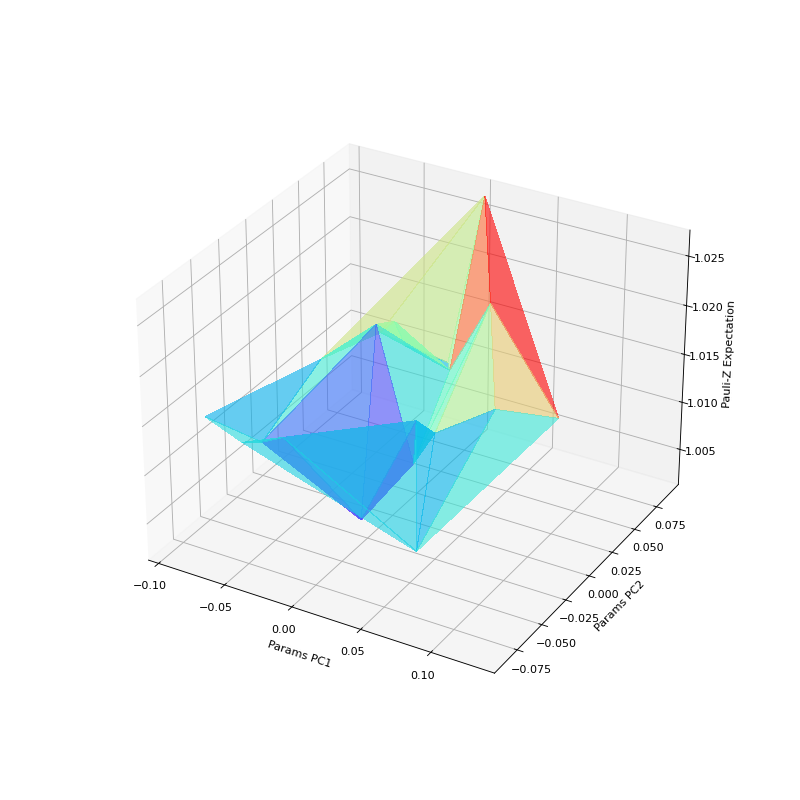

In [30]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
xs = principalDataDF['x']
ys = principalDataDF['y']
zs = principalDataDF['z']

fig = plt.figure(figsize=(10, 10), dpi=80)
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('Params PC1')
ax.set_ylabel('Params PC2')
ax.set_zlabel('Pauli-Z Expectation')

plot = ax.plot_trisurf(xs,
                       ys,
                       zs,
                       cmap=plt.get_cmap('rainbow'),
                       linewidth=1,
                       antialiased=False,
                       alpha=0.6)

plt.show()